In [1]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Umsatzdaten laden
df_umsatz = pd.read_csv('data/umsatzdaten_gekuerzt.csv')
df_test = pd.read_csv('test.csv')
df_holidays = pd.read_csv('holidays_germany.csv')
df_wetter = pd.read_csv('data/wetter.csv')
df_kiwo = pd.read_csv('data/kiwo.csv')

# Datum konvertieren
df_umsatz['Datum'] = pd.to_datetime(df_umsatz['Datum'], errors='coerce')
df_test['Datum'] = pd.to_datetime(df_test['Datum'], errors='coerce')

# Zusammenführen 
df_umsatz = pd.concat([df_umsatz, df_test], ignore_index=True)

# Nach Datum sortieren
df_umsatz = df_umsatz.sort_values(by='Datum')

df_wetter['Datum'] = pd.to_datetime(df_wetter['Datum'], errors='coerce')
df_kiwo['Datum'] = pd.to_datetime(df_kiwo['Datum'], errors='coerce')

df_holidays['date'] = pd.to_datetime(df_holidays['date'], errors='coerce')
df_holidays = df_holidays.rename(columns={'date': 'Datum'})

merged_wetter_umsatz = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
merged_kiwo = pd.merge(merged_wetter_umsatz, df_kiwo, on='Datum', how='left')
df_merged = pd.merge(merged_kiwo, df_holidays, on='Datum', how='left')

df_merged = df_merged.rename(columns={'holiday': 'Feiertage'})

print("Min:", df_merged['Datum'].min())
print("Max:", df_merged['Datum'].max())

display(df_merged.head())
print(df_merged.shape)
print(df_merged['Datum'].is_monotonic_increasing)






Min: 2013-07-01 00:00:00
Max: 2019-07-30 00:00:00


,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Feiertage
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,NaN,NaN
1,1307013,2013-07-01,3,201.198426,6.0,17.8375,15.0,20.0,NaN,NaN
2,1307014,2013-07-01,4,65.890169,6.0,17.8375,15.0,20.0,NaN,NaN
3,1307015,2013-07-01,5,317.475875,6.0,17.8375,15.0,20.0,NaN,NaN
4,1307012,2013-07-01,2,535.856285,6.0,17.8375,15.0,20.0,NaN,NaN


(11164, 10)
True


In [4]:
# Data Cleaning

df_merged['Datum'] = pd.to_datetime(df_merged['Datum'], errors='coerce')
df_merged['Monat'] = df_merged['Datum'].dt.month
df_merged['Wochentag'] = df_merged['Datum'].dt.weekday
df_merged = df_merged.drop_duplicates()

# Wetter- und Feature-Daten bereinigen
df_merged['Temperatur'] = df_merged['Temperatur'].fillna(df_merged['Temperatur'].mean())
df_merged['KielerWoche'] = df_merged['KielerWoche'].fillna(0)
df_merged['Wettercode'] = df_merged['Wettercode'].fillna(0)
df_merged['Bewoelkung'] = df_merged['Bewoelkung'].fillna(df_merged['Bewoelkung'].mean())
df_merged['Windgeschwindigkeit'] = df_merged['Windgeschwindigkeit'].fillna(df_merged['Windgeschwindigkeit'].mean())
df_merged['Feiertage'] = df_merged['Feiertage'].fillna('Kein Feiertag')

df_with_umsatz = df_merged[df_merged['Umsatz'].notna()].copy()
df_without_umsatz = df_merged[df_merged['Umsatz'].isna()].copy()

print(f"Zeilen mit Umsatz: {len(df_with_umsatz)}")
print(f"Zeilen ohne Umsatz (zum Vorhersagen): {len(df_without_umsatz)}")

df_merged.to_csv("data/df_merged.csv", index=False)

print("Min:", df_merged['Datum'].min())
print("Max:", df_merged['Datum'].max())


print(df_merged.isna().sum())
df_merged.head()

Zeilen mit Umsatz: 9334
Zeilen ohne Umsatz (zum Vorhersagen): 1830
Min: 2013-07-01 00:00:00
Max: 2019-07-30 00:00:00
id                        0
Datum                     0
Warengruppe               0
Umsatz                 1830
Bewoelkung                0
Temperatur                0
Windgeschwindigkeit       0
Wettercode                0
KielerWoche               0
Feiertage                 0
Monat                     0
Wochentag                 0
dtype: int64


,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Feiertage,Monat,Wochentag
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0.0,Kein Feiertag,7,0
1,1307013,2013-07-01,3,201.198426,6.0,17.8375,15.0,20.0,0.0,Kein Feiertag,7,0
2,1307014,2013-07-01,4,65.890169,6.0,17.8375,15.0,20.0,0.0,Kein Feiertag,7,0
3,1307015,2013-07-01,5,317.475875,6.0,17.8375,15.0,20.0,0.0,Kein Feiertag,7,0
4,1307012,2013-07-01,2,535.856285,6.0,17.8375,15.0,20.0,0.0,Kein Feiertag,7,0


In [5]:
# Dataset Splitting

train = df_merged[(df_merged['Datum'] >= '2013-07-01') & (df_merged['Datum'] <= '2017-07-31')]
validation = df_merged[(df_merged['Datum'] >= '2017-08-01') & (df_merged['Datum'] <= '2018-07-31')]
test  = df_merged[(df_merged['Datum'] >= '2018-08-01') & (df_merged['Datum'] <= '2019-07-31')]

print("Train shape :", train.shape)
print("Validation shape :", validation.shape)
print("Test shape :", test.shape)

train.to_csv("data/train_data.csv", index=False)
validation.to_csv("data/validation_data.csv", index=False)
test.to_csv("data/test_data.csv", index=False)


Train shape : (7493, 12)
Validation shape : (1841, 12)
Test shape : (1830, 12)


ValueError: could not convert string to float: 'Kein Feiertag'

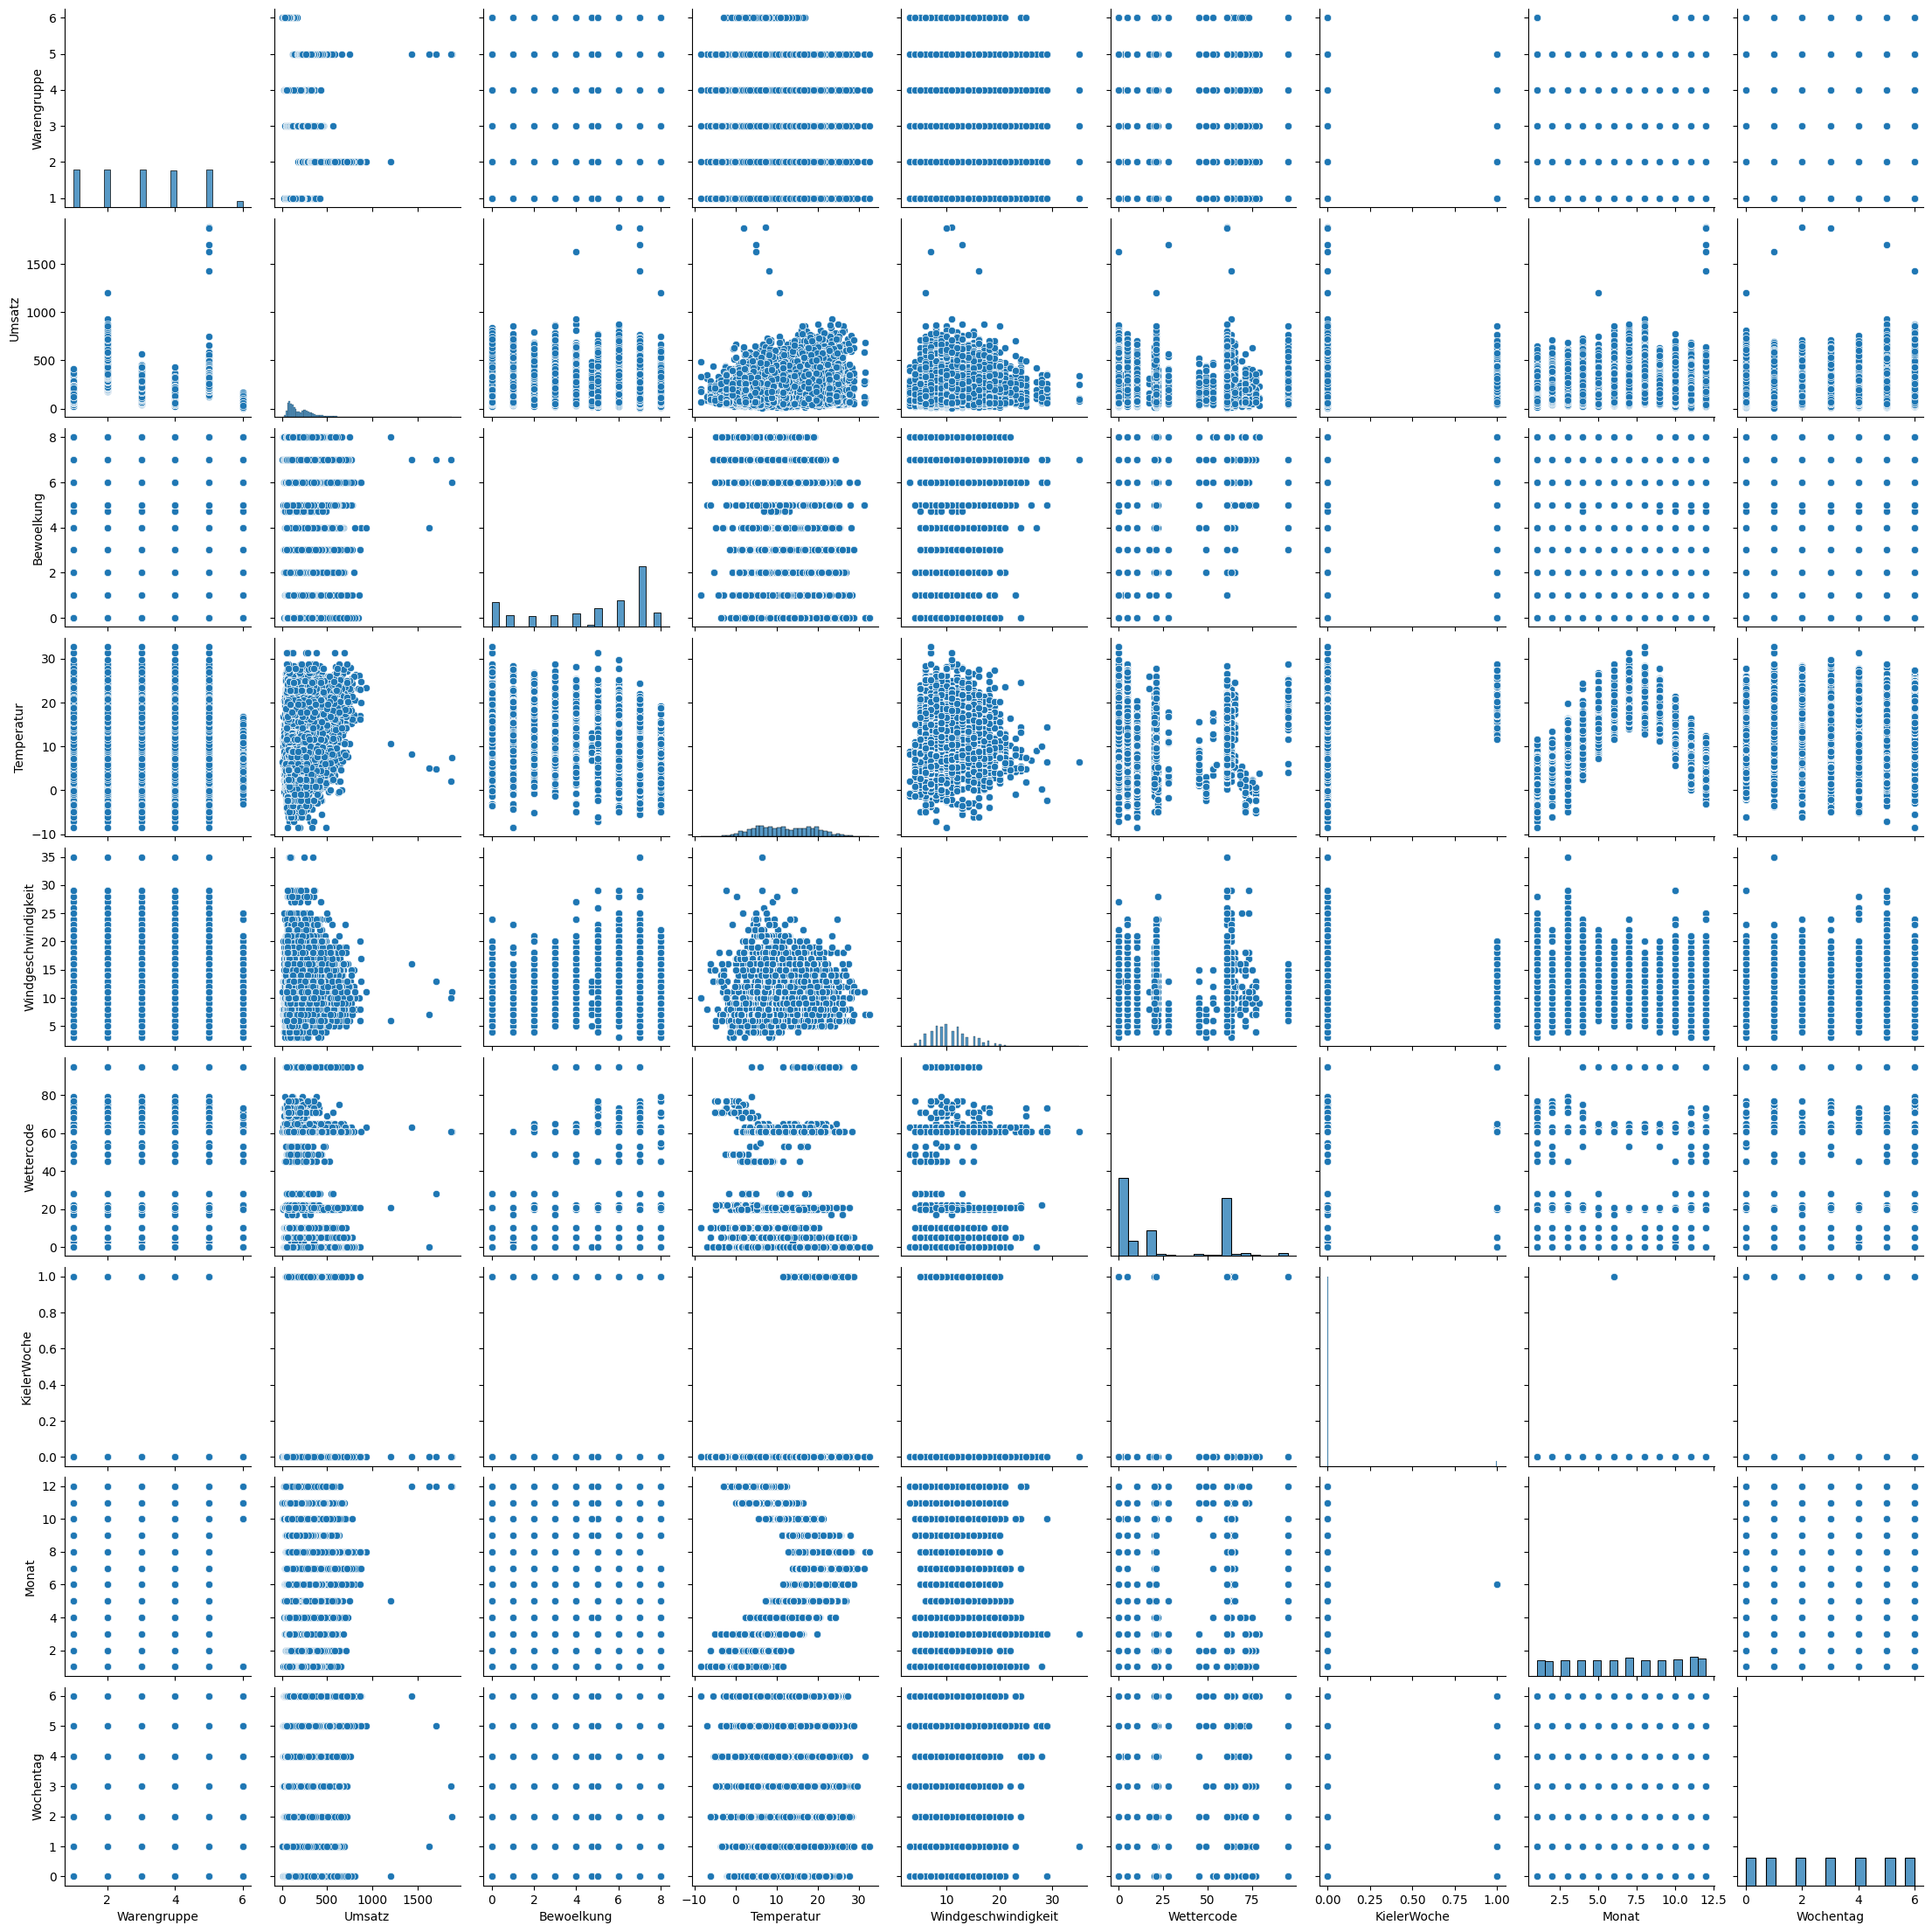

In [9]:
# Pairplots

columns = ['Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'Feiertage', 'Monat', 'Wochentag']

sns.pairplot(df_merged[columns])

df_merged[columns].corr()



,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Monat,Wochentag
count,9.334000e+03,9334,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000
mean,1.559311e+06,2016-01-13 23:56:27.100921344,3.088172,206.749044,4.720876,12.028472,10.974842,27.708699,0.023891,6.654810,3.000536
min,1.307011e+06,2013-07-01 00:00:00,1.000000,7.051201,0.000000,-8.475000,3.000000,0.000000,0.000000,1.000000,0.000000
25%,1.410123e+06,2014-10-12 00:00:00,2.000000,96.897441,3.000000,6.250000,8.000000,0.000000,0.000000,4.000000,1.000000
50%,1.601102e+06,2016-01-10 00:00:00,3.000000,161.900831,6.000000,11.656250,10.000000,20.000000,0.000000,7.000000,3.000000
75%,1.704223e+06,2017-04-22 00:00:00,4.000000,280.644663,7.000000,17.962500,13.000000,61.000000,0.000000,10.000000,5.000000
max,1.807315e+06,2018-07-31 00:00:00,6.000000,1879.461831,8.000000,31.437500,35.000000,95.000000,1.000000,12.000000,6.000000
std,1.512503e+05,NaN,1.489002,144.545189,2.636331,7.226626,4.128431,28.390122,0.152718,3.461902,2.001044


Warengruppe
1    1819
3    1819
5    1819
2    1819
4    1766
6     292
Name: count, dtype: int64
Feiertage
Kein Feiertag                9234
Tag der Deutschen Einheit      25
Ostermontag                    25
Christi Himmelfahrt            25
Pfingstmontag                  20
Erster Mai                      5
Name: count, dtype: int64


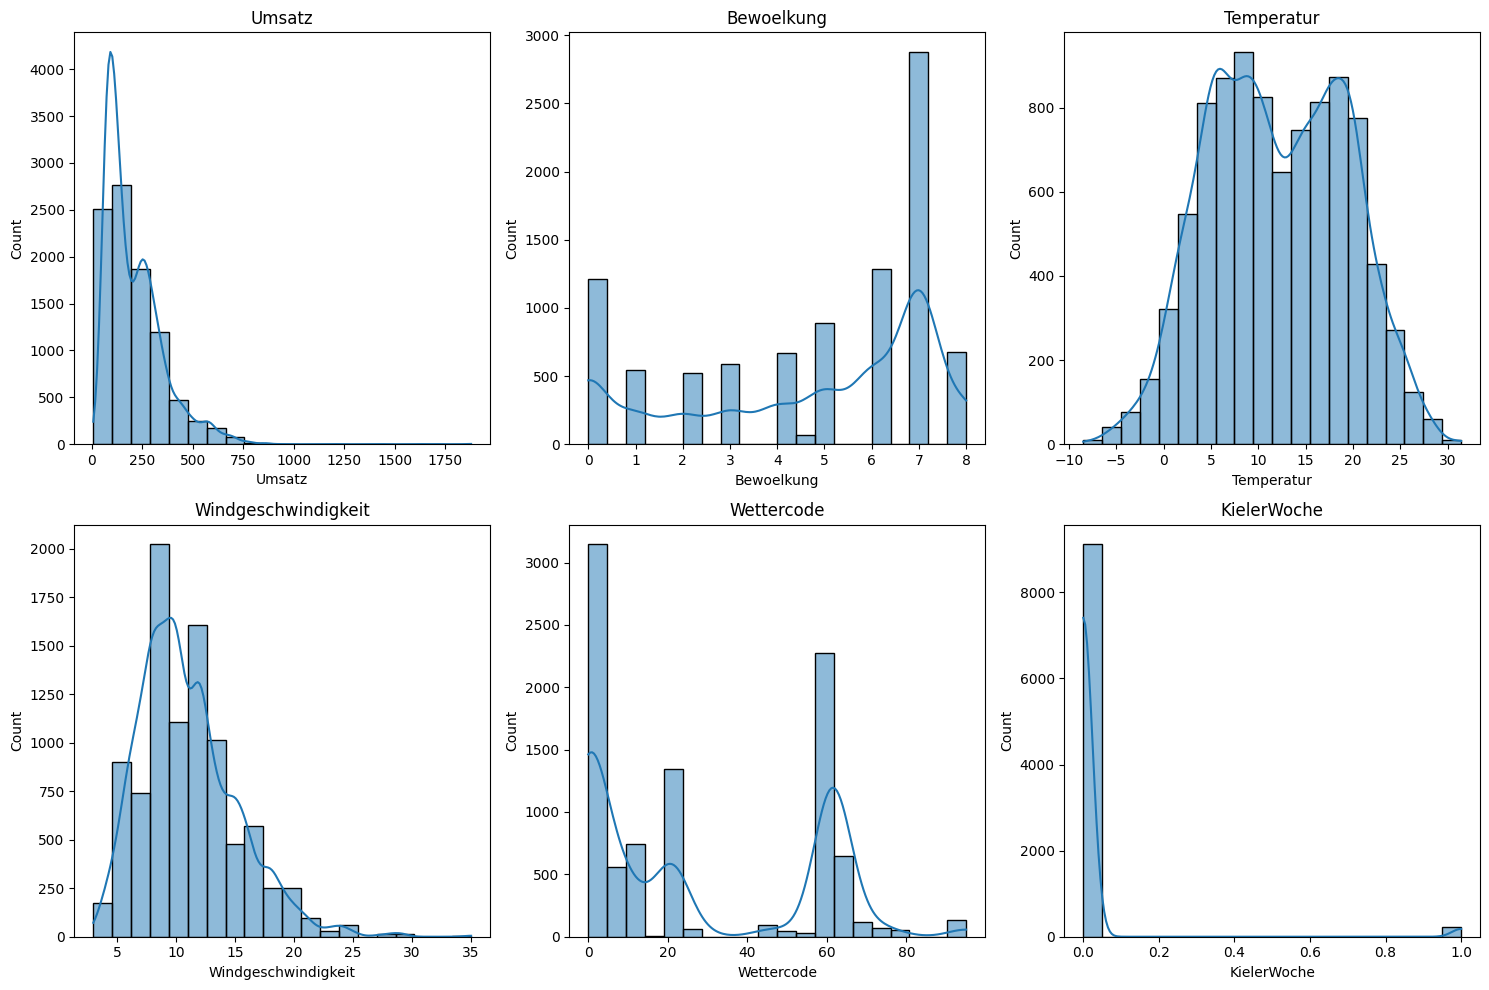

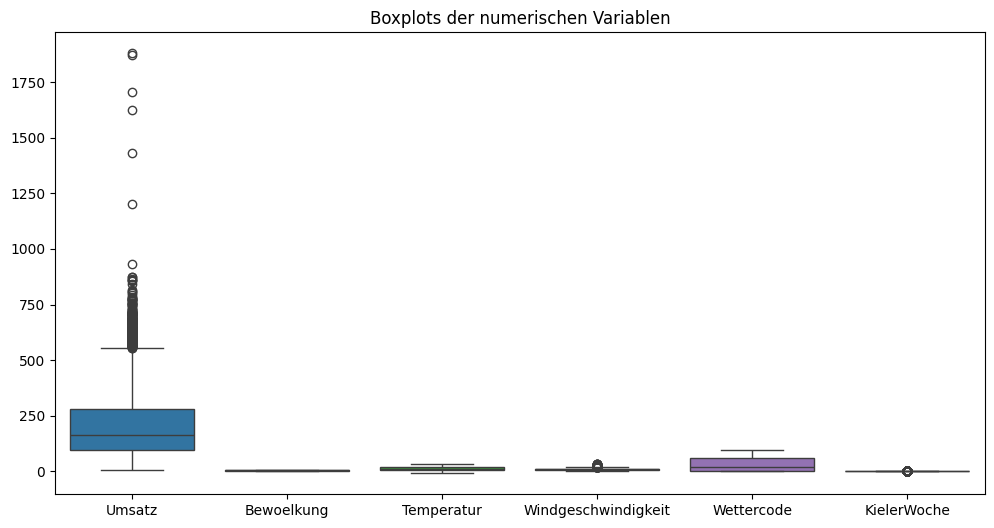

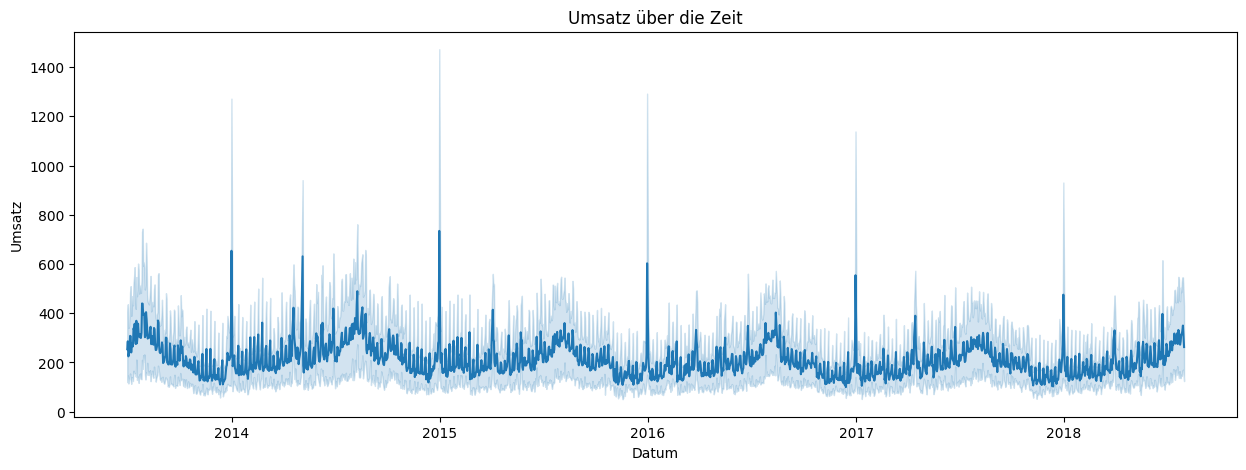

/tmp/ipykernel_20153/2591877749.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_merged, x='Warengruppe', y='Umsatz', ci=None)


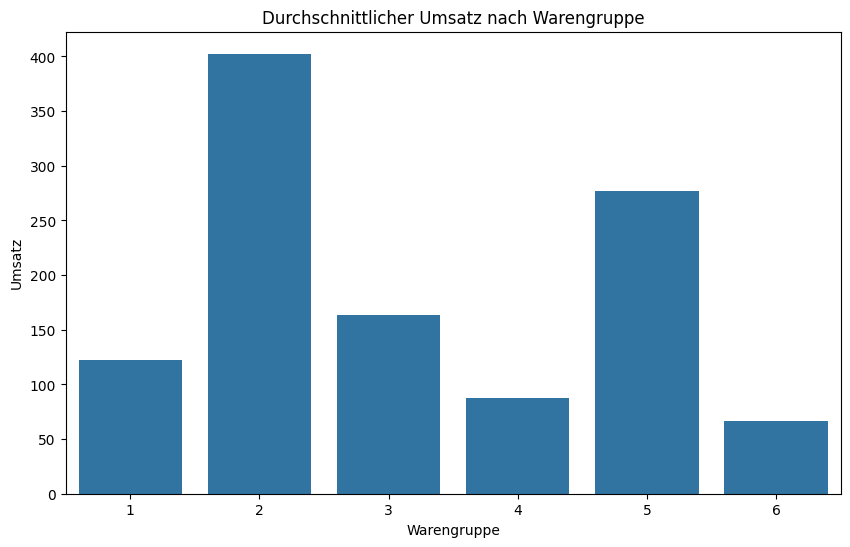

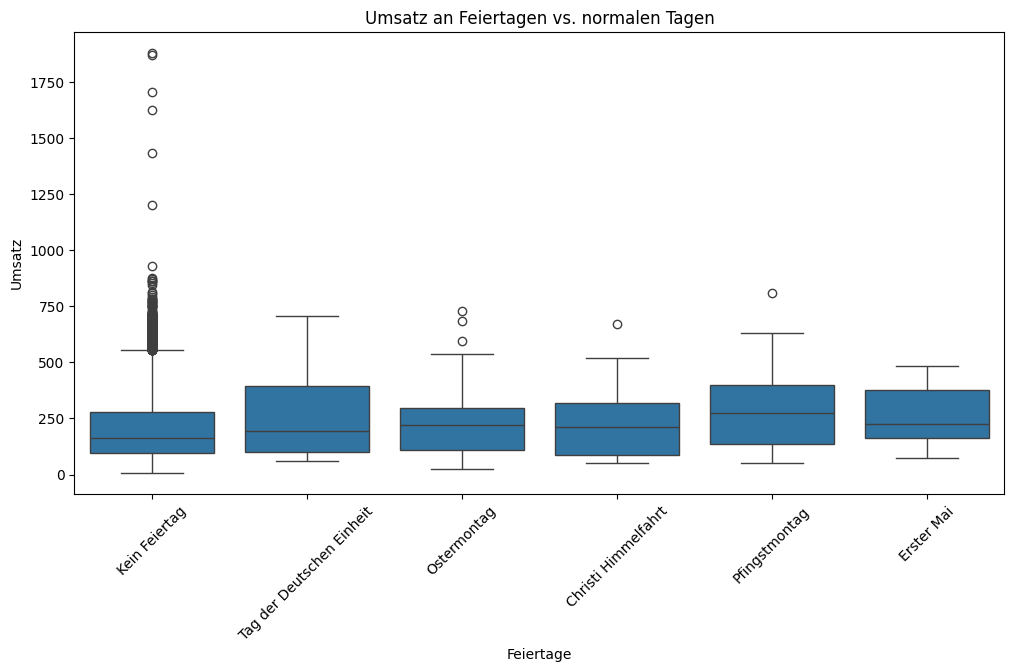

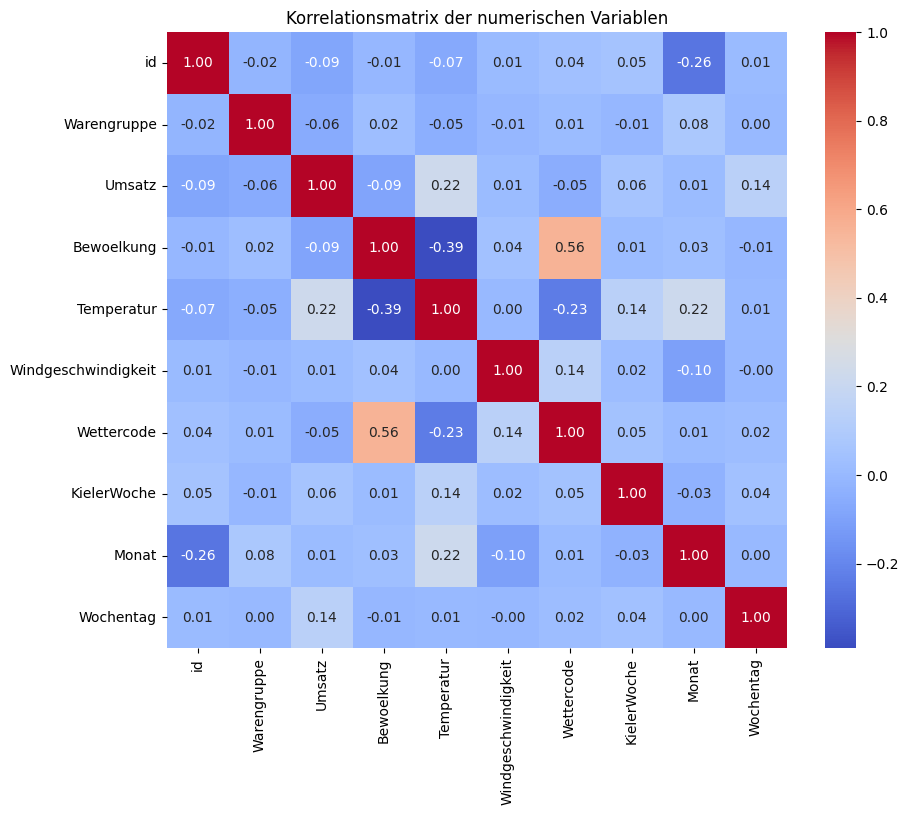

/tmp/ipykernel_20153/2591877749.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_merged, x='Wochentag', y='Umsatz', ci=None)


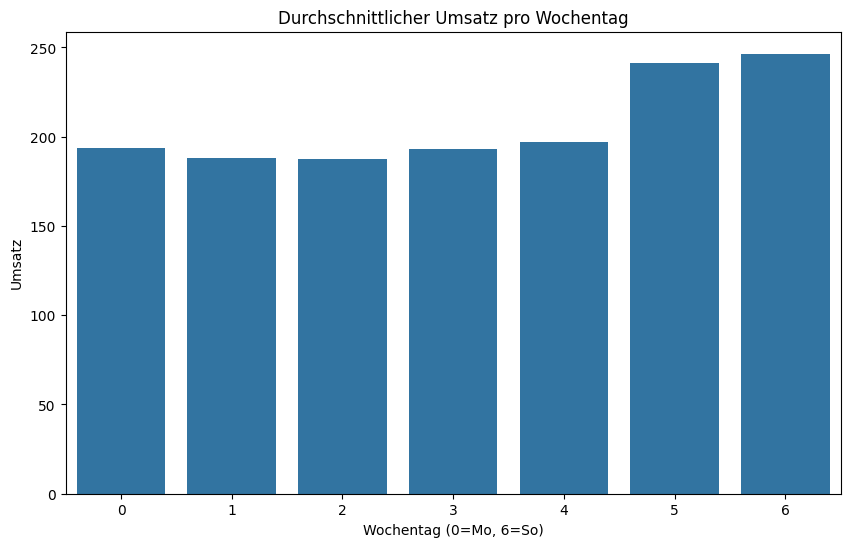

In [6]:
# Descriptive statistics and visualizations for the respective variables

display(df_merged.describe())
df_merged.isna().sum()


print(df_merged['Warengruppe'].value_counts())
print(df_merged['Feiertage'].value_counts())

# Histogramme für numerische Variablen
numerische_spalten = ['Umsatz', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche']

plt.figure(figsize=(15,10))
for i, col in enumerate(numerische_spalten, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_merged[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()
kde=True 

# Boxplots für numerische Variablen (Ausreißer erkennen)
plt.figure(figsize=(12,6))
sns.boxplot(data=df_merged[numerische_spalten])
plt.title("Boxplots der numerischen Variablen")
plt.show()

# Umsatz über die Zeit
plt.figure(figsize=(15,5))
sns.lineplot(data=df_merged, x='Datum', y='Umsatz')
plt.title("Umsatz über die Zeit")
plt.xlabel("Datum")
plt.ylabel("Umsatz")
plt.show()

# Umsatz nach Warengruppe
plt.figure(figsize=(10,6))
sns.barplot(data=df_merged, x='Warengruppe', y='Umsatz', ci=None)
plt.title("Durchschnittlicher Umsatz nach Warengruppe")
plt.show()

# Umsatz an Feiertagen vs. normalen Tagen
plt.figure(figsize=(12,6))
sns.boxplot(data=df_merged, x='Feiertage', y='Umsatz')
plt.xticks(rotation=45)
plt.title("Umsatz an Feiertagen vs. normalen Tagen")
plt.show()

# Korrelationsmatrix
numerische_df = df_merged.select_dtypes(include='number')

# Korrelationsmatrix plotten
plt.figure(figsize=(10,8))
sns.heatmap(numerische_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korrelationsmatrix der numerischen Variablen")
plt.show()

# Wochentag-Analyse
df_merged['Wochentag'] = df_merged['Datum'].dt.weekday  # 0 = Montag

plt.figure(figsize=(10,6))
sns.barplot(data=df_merged, x='Wochentag', y='Umsatz', ci=None)
plt.title("Durchschnittlicher Umsatz pro Wochentag")
plt.xlabel("Wochentag (0=Mo, 6=So)")
plt.show()



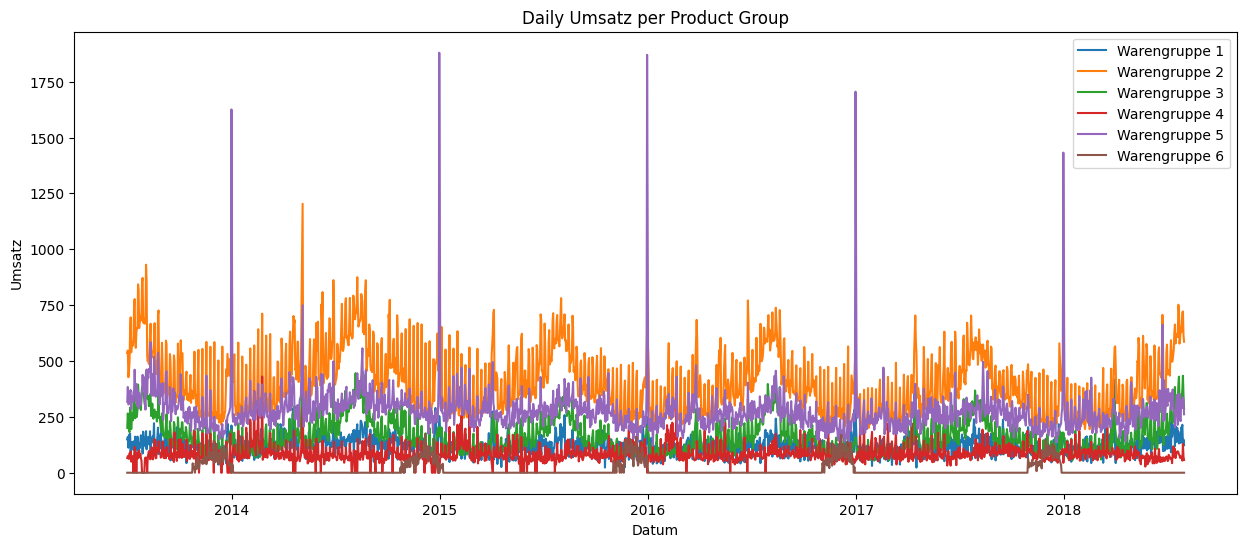

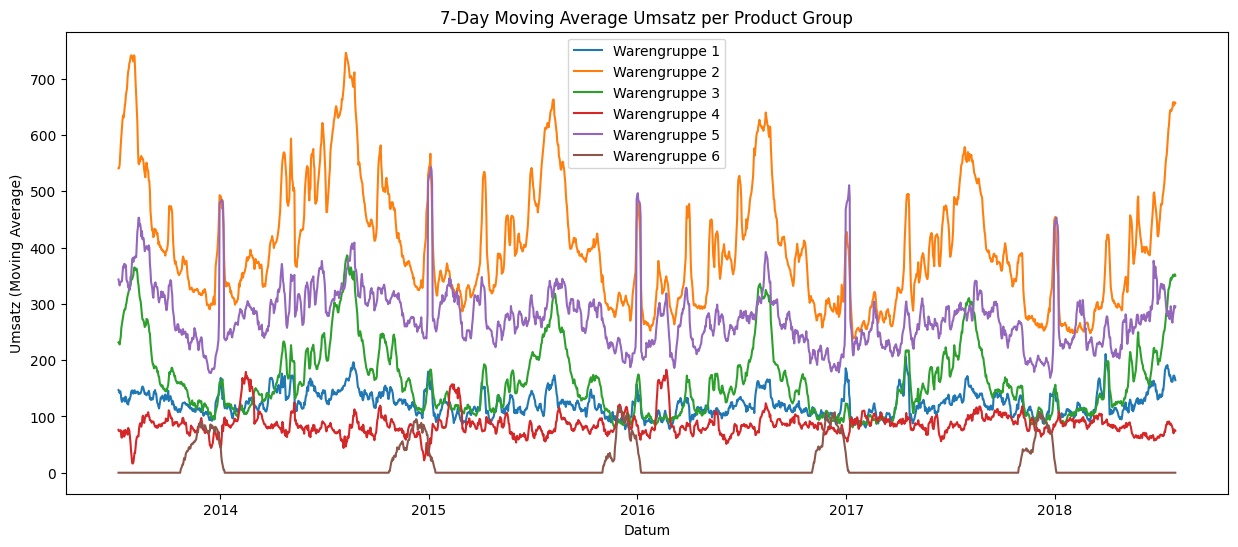

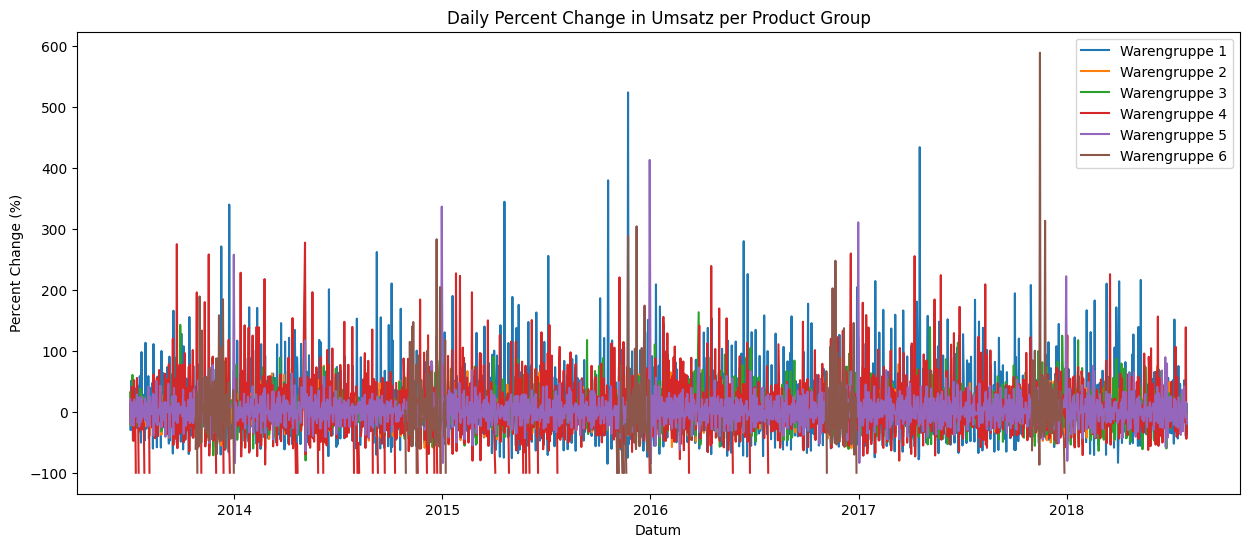

In [53]:
# Time Series

df_merged = df_merged.sort_values('Datum')
df_grouped = df_merged.groupby(['Datum', 'Warengruppe'])['Umsatz'].sum().reset_index()

df_pivot = df_grouped.pivot(index='Datum', columns='Warengruppe', values='Umsatz')
df_pivot = df_pivot.fillna(0)  
df_pivot.head()

# Moving Averages
moving_avg = df_pivot.rolling(window=7).mean()

# Percent Change
pct_change = df_pivot.pct_change() * 100  # convert to percentage

plt.figure(figsize=(15,6))
for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col], label=f'Warengruppe {col}')

plt.title('Daily Umsatz per Product Group')
plt.xlabel('Datum')
plt.ylabel('Umsatz')
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
for col in moving_avg.columns:
    plt.plot(moving_avg.index, moving_avg[col], label=f'Warengruppe {col}')

plt.title('7-Day Moving Average Umsatz per Product Group')
plt.xlabel('Datum')
plt.ylabel('Umsatz (Moving Average)')
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
for col in pct_change.columns:
    plt.plot(pct_change.index, pct_change[col], label=f'Warengruppe {col}')
plt.title('Daily Percent Change in Umsatz per Product Group')
plt.xlabel('Datum')
plt.ylabel('Percent Change (%)')
plt.legend()
plt.show()